In [743]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [744]:
# Load the data
purchase_data = pd.read_csv('/Users/ashutoshkumarsonu/Downloads/purchase_data.csv')

/var/folders/jn/36h36k5x2jx5yg4d_l3hvv900000gn/T/ipykernel_40964/3023947948.py:2: DtypeWarning:

Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.



In [745]:
import warnings
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Data Cleaning and pre-processing -- Feature Engineering

In [746]:
# Check for missing values
print(purchase_data.isnull().sum())

COMPANY_CODE               0
SUPPLIER_CODE              0
INVOICE_ID                 0
INVOICE_DATE            8830
SUPPLIER_PRODUCT_ID        2
RESTURANT_PRODUCT_ID       0
COMPANY_NAME               0
SUPPLIER_NAME              0
SUPPLIER_PRODUCT           0
RESTURANT_PRODUCT          0
PROD_UNIT_PRICE            0
PROD_QTY                 154
TOTAL_AMOUNT               0
Cmp_DtGerencial            0
dtype: int64


In [747]:
# Check duplicates
print(purchase_data.duplicated().sum())

29910


In [748]:
# Convert the invoice_date column to datetime
purchase_data['INVOICE_DATE'] = pd.to_datetime(purchase_data['INVOICE_DATE'], errors='coerce')

In [749]:
min_date = purchase_data['INVOICE_DATE'].min()
max_date = purchase_data['INVOICE_DATE'].max()
print(f"Data collected from {min_date} to {max_date}")

Data collected from 2014-01-31 00:00:00 to 2024-02-26 00:00:00


In [750]:
# Identify missing dates
missing_dates_count = purchase_data['INVOICE_DATE'].isnull().sum()

In [751]:
# Total number of records 
total_records_count = len(purchase_data)
# Calculate the percentage of missing dates 
missing_percentage = (missing_dates_count / total_records_count) * 100
print(f"Total missing invoice dates: {missing_dates_count}")
print(f"Total records: {total_records_count}")
print(f"Percentage of missing invoice dates: {missing_percentage:.2f}%")

Total missing invoice dates: 8830
Total records: 524809
Percentage of missing invoice dates: 1.68%


# imputing missing dates

In [752]:
# Handle missing data
median_date = purchase_data['INVOICE_DATE'].median()  #here i have used the median inputation methods. other ML Methods can be explored too
purchase_data['INVOICE_DATE'].fillna(median_date, inplace=True) # filled the missing date with median date

In [753]:
# Create a flag for imputed data
purchase_data['imputed_invoice_date'] = purchase_data['INVOICE_DATE'].isnull().astype(int)

In [754]:
print(f"Total missing invoice dates: {missing_dates_count}")
print(f"Missing dates imputed with median date: {median_date}")

Total missing invoice dates: 8830
Missing dates imputed with median date: 2022-01-13 00:00:00


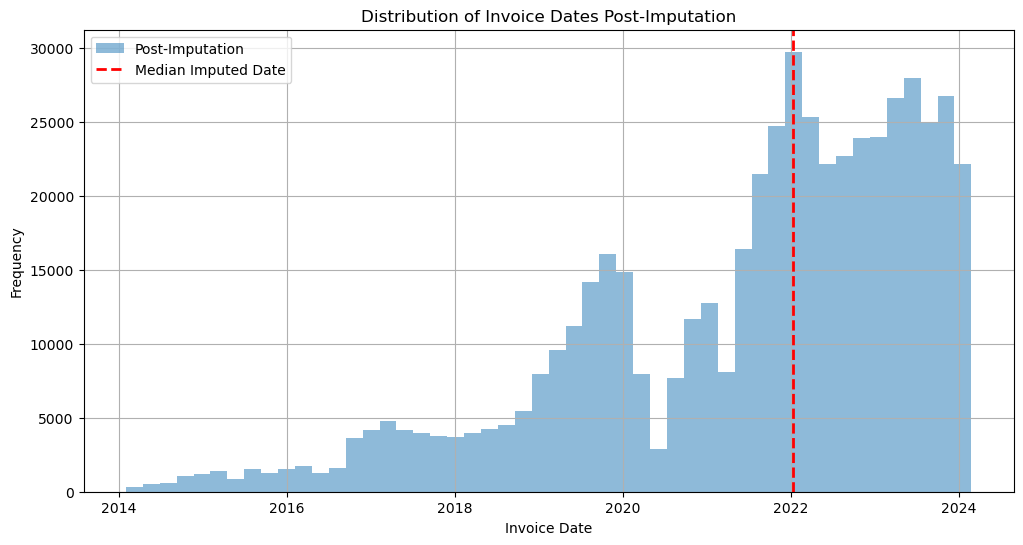

In [755]:
# distribution graph
plt.figure(figsize=(12, 6))
purchase_data['INVOICE_DATE'].hist(bins=50, alpha=0.5, label='Post-Imputation')
plt.axvline(median_date, color='r', linestyle='dashed', linewidth=2, label='Median Imputed Date')
plt.legend()
plt.title('Distribution of Invoice Dates Post-Imputation')
plt.xlabel('Invoice Date')
plt.ylabel('Frequency')
plt.show()

# encoding categorical data

In [756]:
from sklearn.preprocessing import LabelEncoder

In [757]:
# function to apply LabelEncoder to categorical features
def label_encode_ids(df, columns):
    label_encoder = LabelEncoder()
    for col in columns:
        df[col + '_CODE'] = label_encoder.fit_transform(df[col])
    return df

In [758]:
# before doing the encoding convert all the codes to strings for uniform data type 
purchase_data['COMPANY_CODE'] = purchase_data['COMPANY_CODE'].astype(str)
purchase_data['SUPPLIER_CODE'] = purchase_data['SUPPLIER_CODE'].astype(str)
purchase_data['SUPPLIER_PRODUCT_ID'] = purchase_data['SUPPLIER_PRODUCT_ID'].astype(str)

In [759]:
# Apply label encoding to ids of company, supplier, and item
purchase_data = label_encode_ids(purchase_data, ['COMPANY_CODE', 'SUPPLIER_CODE', 'SUPPLIER_PRODUCT_ID'])

In [760]:
# Added new features from invoice date
purchase_data['year'] = purchase_data['INVOICE_DATE'].dt.year
purchase_data['month'] = purchase_data['INVOICE_DATE'].dt.month
purchase_data['day'] = purchase_data['INVOICE_DATE'].dt.day
purchase_data['day_of_week'] = purchase_data['INVOICE_DATE'].dt.dayofweek

# Check for missing values
print(purchase_data.isnull().sum())

COMPANY_CODE                  0
SUPPLIER_CODE                 0
INVOICE_ID                    0
INVOICE_DATE                  0
SUPPLIER_PRODUCT_ID           0
RESTURANT_PRODUCT_ID          0
COMPANY_NAME                  0
SUPPLIER_NAME                 0
SUPPLIER_PRODUCT              0
RESTURANT_PRODUCT             0
PROD_UNIT_PRICE               0
PROD_QTY                    154
TOTAL_AMOUNT                  0
Cmp_DtGerencial               0
imputed_invoice_date          0
COMPANY_CODE_CODE             0
SUPPLIER_CODE_CODE            0
SUPPLIER_PRODUCT_ID_CODE      0
year                          0
month                         0
day                           0
day_of_week                   0
dtype: int64


# EXPLORATORY DATA ANALYSIS
# UNIVARIANT ANALYSIS - PURCHASE PRICE DISTRIBUTION

In [761]:
purchase_data = purchase_data[purchase_data['TOTAL_AMOUNT'] > 0]

In [762]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler # to normalize 
from scipy.stats import shapiro, anderson, probplot

In [763]:
scaler = MinMaxScaler()
# transform the prices to a range of 0 to 1. Scaling can  help in identifying outliers more effectively.
purchase_data['normalized_purchase_price'] = scaler.fit_transform(purchase_data[['TOTAL_AMOUNT']])

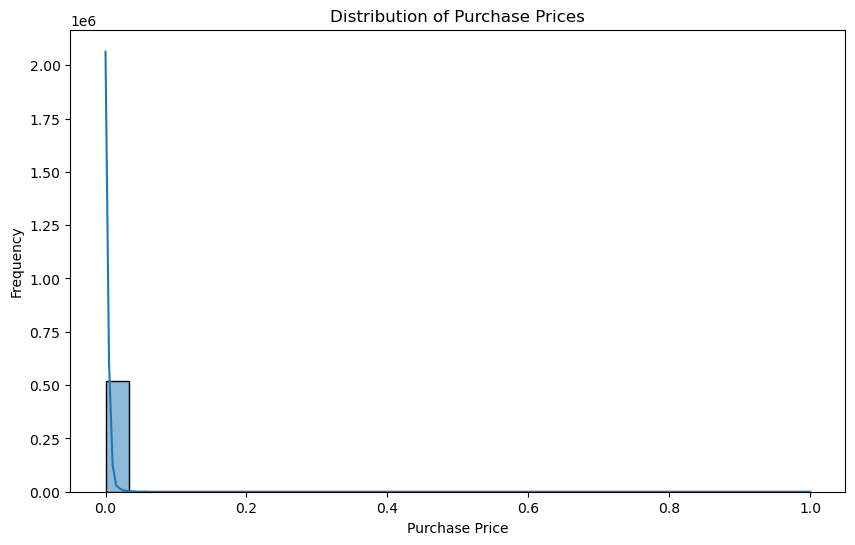

In [764]:
# Histogram of purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['normalized_purchase_price'], bins=30, kde=True)
plt.title('Distribution of Purchase Prices')
plt.xlabel('Purchase Price')
plt.ylabel('Frequency')
plt.show()


# the original data is highly right skewed and does not follow a normal distribution. that's why we are going to perform the log transformation to reduce the skewness

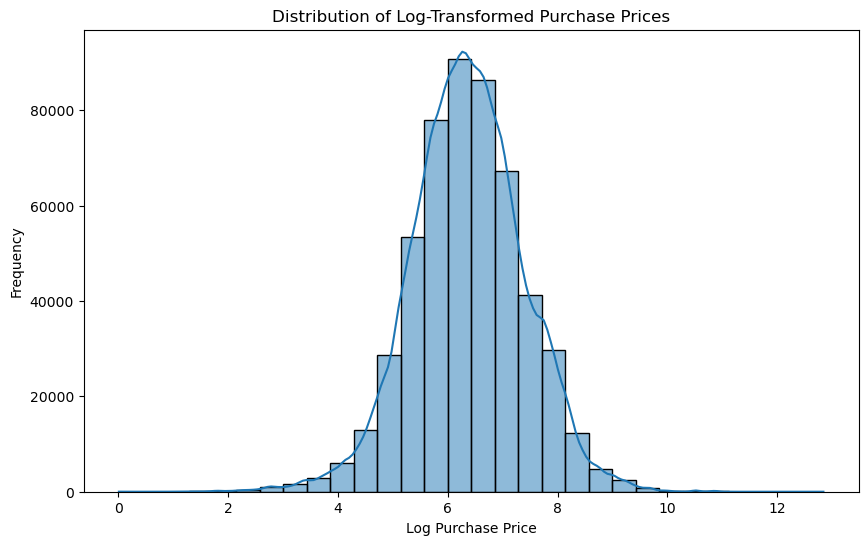

In [765]:
# Log transform the purchase prices
purchase_data['log_purchase_price'] = np.log1p(purchase_data['TOTAL_AMOUNT'])
# Plot the distribution of log-transformed purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['log_purchase_price'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Purchase Prices')
plt.xlabel('Log Purchase Price')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Q-Q Plot of Log-Transformed Data')

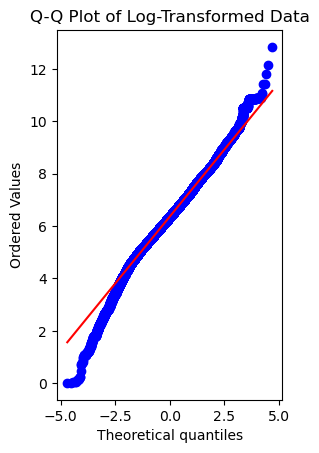

In [766]:
# Q-Q Plot
plt.subplot(1, 2, 2)
probplot(purchase_data['log_purchase_price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Data')

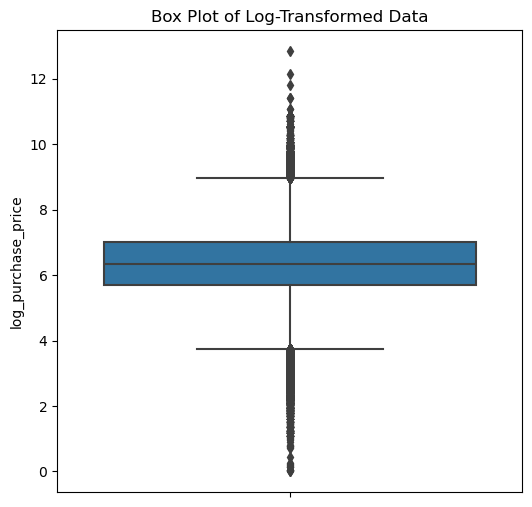

In [767]:
# Box Plot
plt.figure(figsize=(6, 6))
sns.boxplot(y=purchase_data['log_purchase_price'])
plt.title('Box Plot of Log-Transformed Data')
plt.show()

# as checked earlier there were no null values in total amount column
# checked if log transformed total amount data has the null values in it because the presence of zero or negative values in the original data can result in null (NaN) values in the transformed column and on investigation we found that there were 0 and negative values whhich i 

In [769]:
print(purchase_data['log_purchase_price'].isnull().sum())
print(np.isinf(purchase_data['log_purchase_price']).sum())

0
0


# on debugg found that: after doing the log tranformation we are getting the null values thats because When applying a log transformation, the presence of zero or negative values in the original data can result in null (NaN) values in the transformed column. 
# This is because the logarithm of zero or a negative number is undefined in the real number domain

# considering it to be the case of item returned, this could not be relevent to our price prediction model.thats why we have filtered such data above.

# UNIT PRICE DISTRIBUTION 

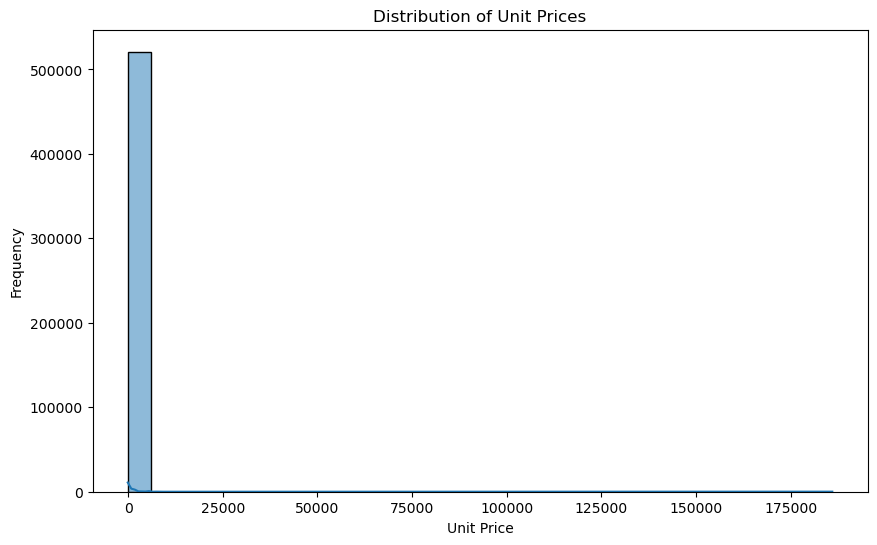

In [770]:
# Histogram of purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['PROD_UNIT_PRICE'], bins=30, kde=True)
plt.title('Distribution of Unit Prices')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.show()

In [448]:
purchase_data = purchase_data[purchase_data['PROD_UNIT_PRICE'] > 0]

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log1p



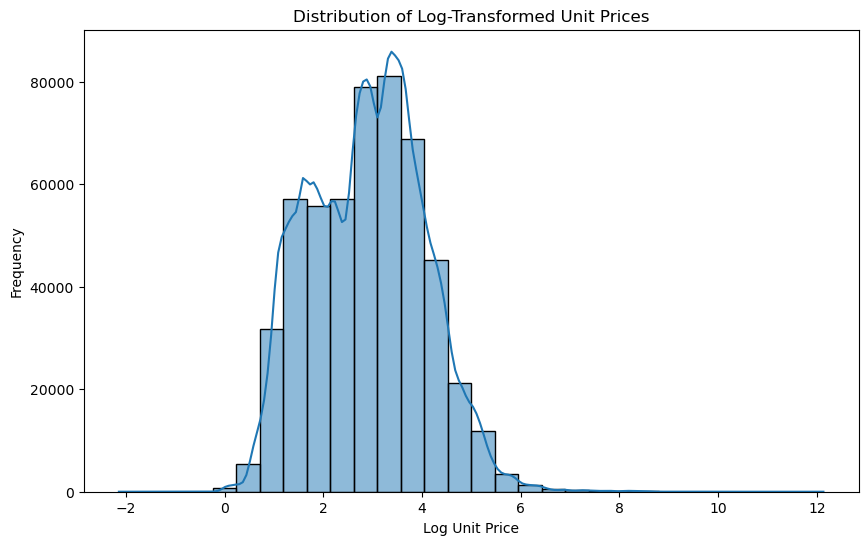

In [771]:
# Log transform the unit prices
purchase_data['log_prod_unit_price'] = np.log1p(purchase_data['PROD_UNIT_PRICE'])

# Plot the distribution of log-transformed purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['log_prod_unit_price'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Unit Prices')
plt.xlabel('Log Unit Price')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Q-Q Plot of Log-Transformed Data')

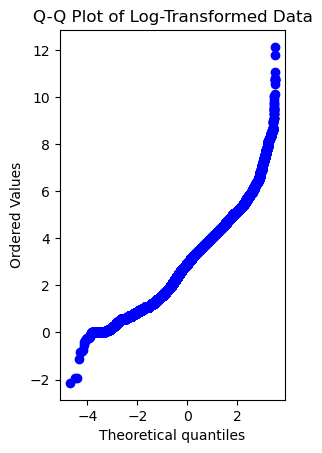

In [772]:
# Q-Q Plot
plt.subplot(1, 2, 2)
probplot(purchase_data['log_prod_unit_price'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Data')

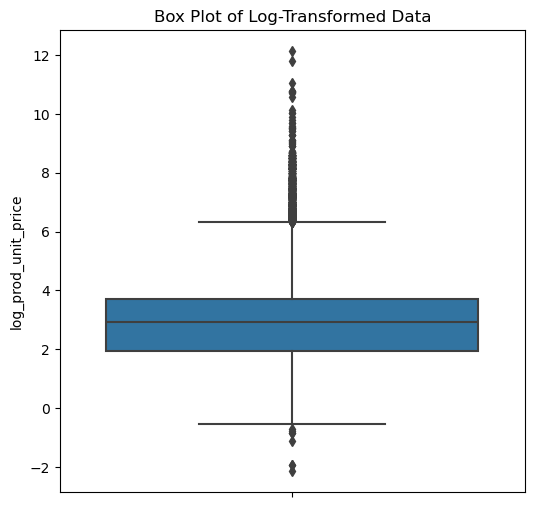

In [773]:
# Box Plot
plt.figure(figsize=(6, 6))
sns.boxplot(y=purchase_data['log_prod_unit_price'])
plt.title('Box Plot of Log-Transformed Data')
plt.show()

# PROD QTY DISTRIBUTION

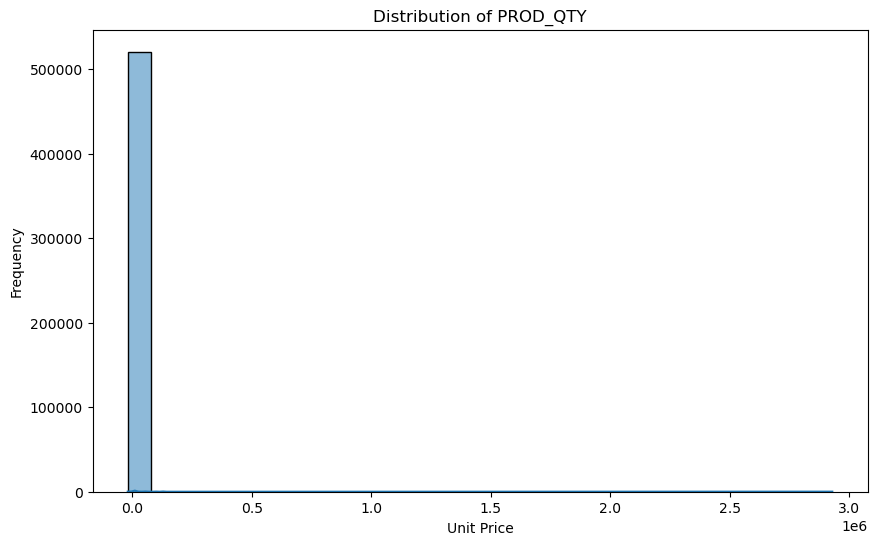

In [774]:
# Histogram of purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['PROD_QTY'], bins=30, kde=True)
plt.title('Distribution of PROD_QTY')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.show()

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log1p



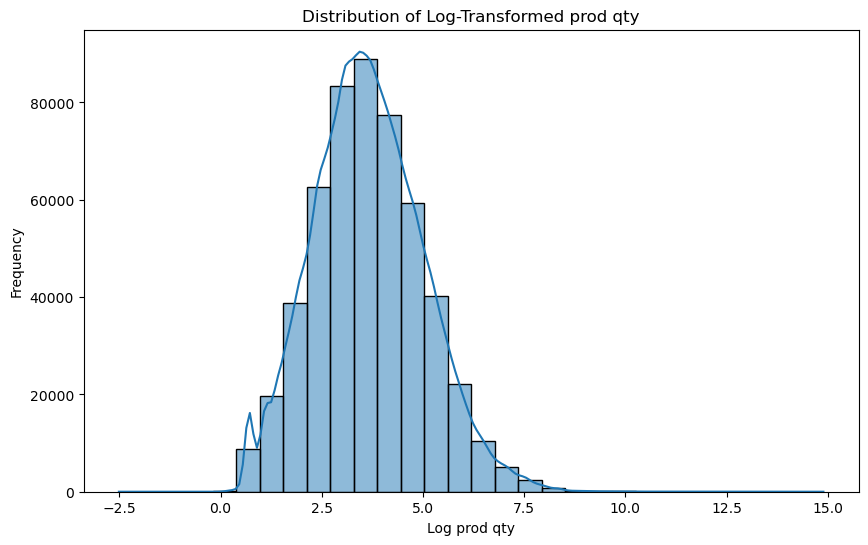

In [775]:
# Log transform the unit prices
purchase_data['log_prod_qty'] = np.log1p(purchase_data['PROD_QTY'])

# Plot the distribution of log-transformed purchase prices
plt.figure(figsize=(10, 6))
sns.histplot(purchase_data['log_prod_qty'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed prod qty')
plt.xlabel('Log prod qty')
plt.ylabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Q-Q Plot of Log-Transformed Data')

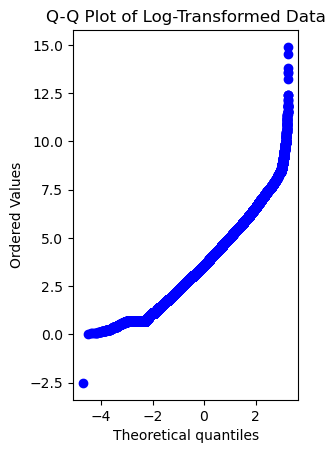

In [776]:
# Q-Q Plot
plt.subplot(1, 2, 2)
probplot(purchase_data['log_prod_qty'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Log-Transformed Data')

In [777]:
purchase_data.columns

Index(['COMPANY_CODE', 'SUPPLIER_CODE', 'INVOICE_ID', 'INVOICE_DATE',
       'SUPPLIER_PRODUCT_ID', 'RESTURANT_PRODUCT_ID', 'COMPANY_NAME',
       'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'RESTURANT_PRODUCT',
       'PROD_UNIT_PRICE', 'PROD_QTY', 'TOTAL_AMOUNT', 'Cmp_DtGerencial',
       'imputed_invoice_date', 'COMPANY_CODE_CODE', 'SUPPLIER_CODE_CODE',
       'SUPPLIER_PRODUCT_ID_CODE', 'year', 'month', 'day', 'day_of_week',
       'normalized_purchase_price', 'log_purchase_price',
       'log_prod_unit_price', 'log_prod_qty'],
      dtype='object')

# Insights in data like 
# 1. Total purchases Over time
# 2. Total Purchases Over Time by Company
# 3. Percentage of Companies Buying Below and Above Average Price for an item
# 4. 

In [778]:
# Unique counts for categorical columns
print(purchase_data['SUPPLIER_NAME'].nunique())
print(purchase_data['SUPPLIER_PRODUCT'].nunique())
print(purchase_data['COMPANY_NAME'].nunique())

2695
52227
142


In [779]:
purchase_data.columns

Index(['COMPANY_CODE', 'SUPPLIER_CODE', 'INVOICE_ID', 'INVOICE_DATE',
       'SUPPLIER_PRODUCT_ID', 'RESTURANT_PRODUCT_ID', 'COMPANY_NAME',
       'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'RESTURANT_PRODUCT',
       'PROD_UNIT_PRICE', 'PROD_QTY', 'TOTAL_AMOUNT', 'Cmp_DtGerencial',
       'imputed_invoice_date', 'COMPANY_CODE_CODE', 'SUPPLIER_CODE_CODE',
       'SUPPLIER_PRODUCT_ID_CODE', 'year', 'month', 'day', 'day_of_week',
       'normalized_purchase_price', 'log_purchase_price',
       'log_prod_unit_price', 'log_prod_qty'],
      dtype='object')

In [780]:
purchase_data['YearMonth'] = purchase_data['INVOICE_DATE'].dt.to_period('M')

In [781]:
# Group by year and month to analyze trends over time
df_monthly = purchase_data.groupby(['YearMonth', 'SUPPLIER_PRODUCT_ID']).agg(
    total_amount=pd.NamedAgg(column='PROD_UNIT_PRICE', aggfunc='sum'),
    avg_unit_price=pd.NamedAgg(column='PROD_UNIT_PRICE', aggfunc='mean')
).reset_index()
df_monthly['YearMonth'] = df_monthly['YearMonth'].dt.to_timestamp()

In [782]:
purchase_data['YearMonth']= purchase_data['YearMonth'].dt.to_timestamp()
# Merge monthly average prices with the original data
purchase_data = purchase_data.merge(df_monthly[['YearMonth', 'SUPPLIER_PRODUCT_ID', 'avg_unit_price']], left_on=['YearMonth', 'SUPPLIER_PRODUCT_ID'], right_on=['YearMonth', 'SUPPLIER_PRODUCT_ID'], suffixes=('', '_monthly'))


In [783]:
purchase_data=purchase_data.rename(columns={'avg_unit_price':'avg_unit_price_monthly'})

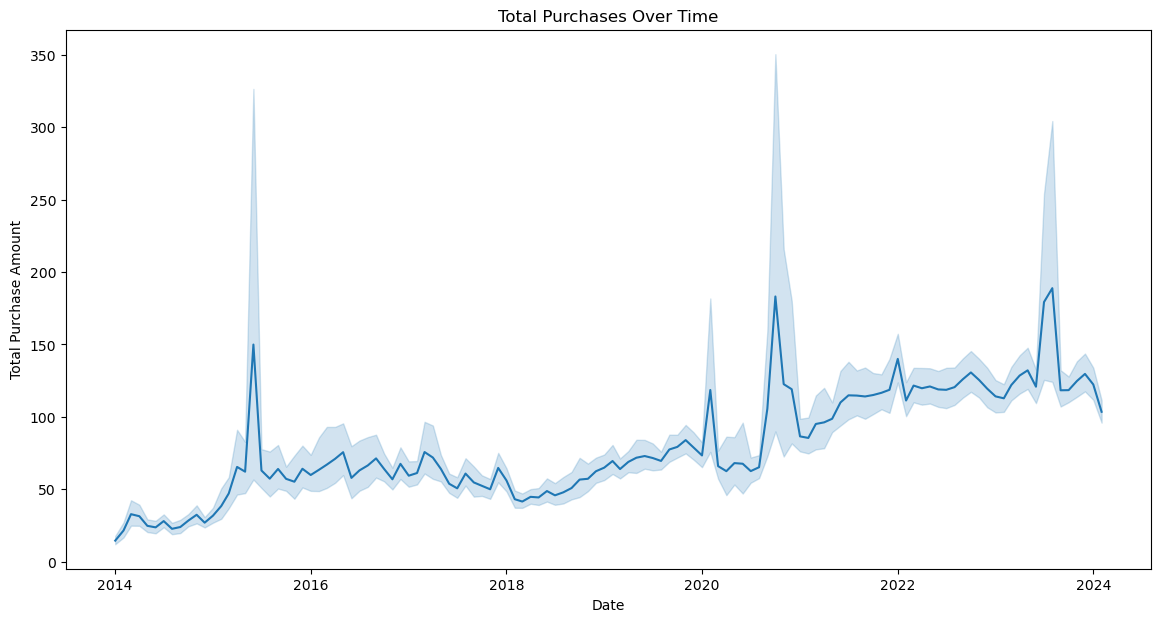

In [784]:
# Plot total purchases over time
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_monthly, x='YearMonth', y='total_amount')
plt.title('Total Purchases Over Time')
plt.xlabel('Date')
plt.ylabel('Total Purchase Amount')
plt.show()

In [785]:
# Calculate overall average prices for each item
average_prices = purchase_data.groupby('SUPPLIER_PRODUCT_ID')['PROD_UNIT_PRICE'].mean().reset_index()
average_prices.columns = ['SUPPLIER_PRODUCT_ID', 'AVERAGE_UNIT_PRICE']

In [786]:
# Merge average prices with the original data
purchase_data = purchase_data.merge(average_prices, on='SUPPLIER_PRODUCT_ID')

In [787]:
# Determine if companies are buying below or above average price
purchase_data['PRICE_COMPARISON'] = np.where(purchase_data['PROD_UNIT_PRICE'] < purchase_data['AVERAGE_UNIT_PRICE'], 'below', 'above')

In [788]:
# Summary of companies buying below and above average price  -- won't required
price_comparison_summary = purchase_data.groupby(['SUPPLIER_PRODUCT_ID', 'PRICE_COMPARISON']).size().unstack().fillna(0)
price_comparison_summary = price_comparison_summary.div(price_comparison_summary.sum(axis=1), axis=0) * 100

In [825]:
# Calculate total revenue for each item and select top 50 best-selling items
#purchase_data['TOTAL_REVENUE'] = purchase_data['PROD_UNIT_PRICE'] * purchase_data['quantity']
top_items = sorted(purchase_data.groupby('SUPPLIER_PRODUCT')['TOTAL_AMOUNT'].sum().nlargest(50).index)

In [828]:
# Filter data to include only top 50 best-selling items
df_top_items = purchase_data[purchase_data['SUPPLIER_PRODUCT'].isin(top_items)]

In [829]:
top_items

['ABOBORA ITALIA',
 'AMSTEL 24X600ML RETOR RV',
 'ANTARCTICA PILSEN GFA VD 1L COM TTC',
 'BECKS N 600 ML',
 'BECKS N LONG NECK 330ML SIX-PACK SHRINK C/4',
 'BUDWEISER OW 330ML CX C/24',
 'CEBOLA',
 'CENOURA',
 'CHOPP BRAHMA CLARO BARRIL KEG 50L',
 'CHOPP BRAHMA CLARO BARRIL KEG 50L          11,5984',
 'CHOPP HEINEKEN CLARO 50L RV',
 'COCA COLA KS 24X290ML',
 'COCA COLA LT 15X310ML',
 'COCA S/A LT 12X310ML',
 'COENTRO',
 'COLORADO APPIA ONE WAY 600ML CX C-12 ARTE',
 'COLORADO LAGER ONE WAY 600ML CX C-12 ARTE',
 'CORONA EXTRA N LONG NECK 330ML CX C/24 NPAL',
 'COSTELA P. AGULHA KG',
 'CRYSTAL MBJ CG PT 12X500 RV',
 'CRYSTAL MBJ SG PT 12X500 RV',
 'FANTA LAR LT 12X310ML',
 'GUARANA CHP ANTARCTICA DIET LATA 350ML SH C/12 NPAL',
 'GUARANA CHP ANTARCTICA LATA 350ML SH C/12 NPAL',
 'H2OH LIMAO C/GAS PET 500ML CAIXA C/12',
 'H2OH LIMONETO PET 500ML SHRINK C/12 NPAL',
 'HEINEKEN 24X600ML RET RV',
 'HEINEKEN LN 6X330ML RV',
 'HEINEKEN LN ZERO 6X330ML RV',
 'LARANJA PERA',
 'LIMAO SICILIANO',
 'M

In [830]:
import ipywidgets as widgets
from IPython.display import display, HTML
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, clear_output

In [831]:
output = widgets.Output()

In [832]:
# Create interactive filter for top 50 best-selling items
item_selector = widgets.Dropdown(
    options=top_items,
    description='Select Item:',
    value=top_items[0]
)

In [833]:
def update_plot(selected_item):
    with output:
        clear_output(wait=True)
        new_df = df_top_items[df_top_items['SUPPLIER_PRODUCT'] == selected_item]
        new_df_summary = new_df['PRICE_COMPARISON'].value_counts(normalize=True) * 100

        fig = go.Figure(data=[
            go.Pie(
                labels=new_df_summary.index,
                values=new_df_summary.values,
                hole=0.3
            )
        ])
        fig.update_layout(
            title=f'Percentage of Companies Buying Below and Above Average Price for {selected_item}',
        )
        fig.show()


    
        # Get companies that are buying above average price
        above_avg_companies = new_df[new_df['PRICE_COMPARISON'] == 'above']['COMPANY_NAME'].unique().tolist()


        # Display the companies in a multi-column format
        company_list_html = ''.join([f'<div class="company">{company}</div>' for company in above_avg_companies])
        display(HTML(f"""
            <h3>Companies buying {selected_item} above the average unit price:</h3>
            <div class="company-list">{company_list_html}</div>
            <style>
                .company-list {{
                    display: grid;
                    grid-template-columns: repeat(auto-fill, minmax(150px, 1fr));
                    gap: 10px;
                }}
                .company {{
                    padding: 5px;
                    background-color: #f0f0f0;
                    border-radius: 5px;
                    text-align: center;
                }}
            </style>
        """))

        # Update company selector for second analysis
        #company_selector_new.options = above_avg_companies
        #update_plot_new(item_selector_new.value, year_selector_new.value, company_selector_new.value)
        '''
        print(f"Updated company selector options: {above_avg_companies}")
        company_selector_new.options = above_avg_companies
        if above_avg_companies:
            company_selector_new.value = above_avg_companies[0]
            print(f"Set company selector value to: {company_selector_new.value}")
        update_plot_new(item_selector_new.value, year_selector_new.value, company_selector_new.value)

        '''



In [834]:
def on_item_change(change):
    update_plot(change['new'])

In [835]:
# Link dropdowns to update plot function for second analysis
item_selector.observe(on_item_change, names='value')

In [836]:

# Display dropdowns and initial plots
display(widgets.HBox([item_selector]))
display(output)
update_plot(item_selector.value)


Output()

In [837]:
# filter data with flag above
above_avg_companies = df_top_items[df_top_items['PRICE_COMPARISON'] == 'above']['COMPANY_NAME'].unique()

In [838]:
# Filter data for these companies
New_filtered_data = df_top_items[df_top_items['COMPANY_NAME'].isin(above_avg_companies)]

In [839]:
New_filtered_data.columns

Index(['COMPANY_CODE', 'SUPPLIER_CODE', 'INVOICE_ID', 'INVOICE_DATE',
       'SUPPLIER_PRODUCT_ID', 'RESTURANT_PRODUCT_ID', 'COMPANY_NAME',
       'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'RESTURANT_PRODUCT',
       'PROD_UNIT_PRICE', 'PROD_QTY', 'TOTAL_AMOUNT', 'Cmp_DtGerencial',
       'imputed_invoice_date', 'COMPANY_CODE_CODE', 'SUPPLIER_CODE_CODE',
       'SUPPLIER_PRODUCT_ID_CODE', 'year', 'month', 'day', 'day_of_week',
       'normalized_purchase_price', 'log_purchase_price',
       'log_prod_unit_price', 'log_prod_qty', 'YearMonth',
       'avg_unit_price_monthly', 'AVERAGE_UNIT_PRICE', 'PRICE_COMPARISON'],
      dtype='object')

In [840]:
monthly_avg_price = New_filtered_data.groupby(['year','month', 'SUPPLIER_PRODUCT'])['PROD_UNIT_PRICE'].mean().reset_index()
monthly_avg_price.columns = ['year','month', 'SUPPLIER_PRODUCT', 'monthly_avg_unit_price']

In [841]:
# Merge to get monthly average unit price in the filtered data
New_filtered_data = pd.merge(New_filtered_data, monthly_avg_price, on=['year','month', 'SUPPLIER_PRODUCT'])


In [842]:
# Add a column to indicate if the price is above or below the monthly average
New_filtered_data['PRICE_COMPARISON_MONTHLY'] = New_filtered_data.apply(
    lambda row: 'above' if row['PROD_UNIT_PRICE'] > row['monthly_avg_unit_price'] else 'below', axis=1
)

In [843]:
# Extract years for the dropdown selector
years = New_filtered_data['year'].unique()
companies = sorted(New_filtered_data['COMPANY_NAME'].unique())
New_filtered_data['month_name'] = New_filtered_data['INVOICE_DATE'].dt.strftime('%B')

In [844]:
# Widgets and output for second analysis
item_selector_new = widgets.Dropdown(
    options=sorted(filtered_data['SUPPLIER_PRODUCT'].unique()),
    description='Item:'
)
year_selector_new = widgets.Dropdown(
    options=years,
    description='Year:'
)
company_selector_new = widgets.Dropdown(
    options=companies,  # This will be updated dynamically based on the first analysis
    description='Company:'
)
output_1 = widgets.Output()

In [848]:
# Update plot function for second analysis
def update_plot_new(selected_item, selected_year, selected_company):
    with output_1:
        clear_output(wait=True)
        #print(f"Second analysis parameters - Item: {selected_item}, Year: {selected_year}, Company: {selected_company}")
        filtered_df = New_filtered_data[(New_filtered_data['SUPPLIER_PRODUCT'] == selected_item) & 
                                    (New_filtered_data['year'] == selected_year) &
                                    (New_filtered_data['COMPANY_NAME'] == selected_company)]

        if filtered_df.empty:
            print("No data available for the selected filters.")
            return
        
        # Group by month to get counts of above/below for each month
        monthly_summary = filtered_df.groupby(['month', 'month_name', 'PRICE_COMPARISON_MONTHLY']).size().unstack(fill_value=0)
        monthly_summary = monthly_summary.sort_index(level='month')
        
        # Prepare data for the bar plot
        fig = go.Figure()
        
        if 'above' in monthly_summary.columns:
            fig.add_trace(go.Bar(
                x=monthly_summary.index.get_level_values('month_name'),
                y=monthly_summary['above'],
                name='Above',
                marker_color='red'
            ))
        if 'below' in monthly_summary.columns:
            fig.add_trace(go.Bar(
                x=monthly_summary.index.get_level_values('month_name'),
                y=monthly_summary['below'],
                name='Below',
                marker_color='green'
            ))
        
        fig.update_layout(
            title=f'Monthly Analysis of {selected_item} for {selected_company} in {selected_year}',
            barmode='group',
            xaxis_title='Month',
            yaxis_title='Number of Transactions',
            legend_title='Comparison'
        )
        
        fig.show()

In [849]:
def on_item_change_2(change):
    update_plot_new(item_selector_new.value, year_selector_new.value, company_selector_new.value)

def on_year_change_2(change):
    update_plot_new(item_selector_new.value, year_selector_new.value, company_selector_new.value)

def on_company_change_2(change):
    update_plot_new(item_selector_new.value, year_selector_new.value, company_selector_new.value)


In [850]:
# Link dropdowns to update plot function for second analysis

item_selector_new.observe(on_item_change_2, names='value')
year_selector_new.observe(on_year_change_2, names='value')
company_selector_new.observe(on_company_change_2, names='value')

# Display dropdowns and initial plot for second analysis
display(widgets.HBox([item_selector_new, year_selector_new,company_selector_new]))
display(output_1)
update_plot_new(item_selector_new.value, year_selector_new.value, company_selector_new.value)


Output(outputs=({'name': 'stdout', 'text': 'Second analysis parameters - Item: AMSTEL 24X600ML RETOR RV, Year:…

In [120]:
# Summary statistics by supplier
supplier_summary = purchase_data.groupby('SUPPLIER_NAME').agg({
    'TOTAL_AMOUNT': 'sum',
    'PROD_UNIT_PRICE': ['mean', 'std'],
    'PROD_QTY': 'sum'
}).reset_index()

In [121]:
# Summary statistics by company
company_summary = purchase_data.groupby('COMPANY_NAME').agg({
    'TOTAL_AMOUNT': 'sum',
    'PROD_UNIT_PRICE': ['mean', 'std'],
    'PROD_QTY': 'sum'
}).reset_index()

In [122]:
company_summary

COMPANY_NAME TOTAL_AMOUNT PROD_UNIT_PRICE  \
                                                      sum            mean   
0                                        405      5579.80       84.523077   
1                               Abstrato Bar   1137521.92       48.544683   
2                            Aero Vila Cinco  18092244.18       48.974214   
3                              Alfredos 408n  16888029.54       35.435223   
4                              Alfredos 506s   3585761.18       57.073655   
..                                       ...          ...             ...   
137                            Zel GastroPup     59221.63      155.201794   
138                          Zepelim Burguer   1777601.35       11.443193   
139                               Ziriguidum   1707716.87       27.801282   
140                              Zé Torresmo    341730.84       71.809403   
141  xMarzuk Emporio AC 04/02/22 a  30/06/22     13819.43       31.191636   

                     PROD_QTY  
            std           sum  
0      1.719571  6.596751e+01  
1    125.197966  9.900970e+04  
2    138.954076  1.268765e+06  
3     46.195628  9.577415e+05  
4    274.985115  2.379431e+05  
..          ...           ...  
137   93.717663  9.715312e+02  
138   33.028355  4.050611e+05  
139   64.233030  2.905456e+05  
140  372.740016  2.017829e+04  
141   13.869408  4.689392e+02  

[142 rows x 5 columns]

In [123]:
# Identify top suppliers and companies
top_suppliers = purchase_data.groupby('SUPPLIER_NAME')['TOTAL_AMOUNT'].sum().nlargest(10).index
top_companies = purchase_data.groupby('COMPANY_NAME')['TOTAL_AMOUNT'].sum().nlargest(10).index

In [124]:
# Identify top 10 suppliers based on total purchase amount
top_suppliers = purchase_data.groupby('SUPPLIER_NAME')['TOTAL_AMOUNT'].sum().nlargest(10).index


In [125]:
top_suppliers

Index(['Ambev', 'Brasal Refrigerantes S/A', 'SUPER ADEGA',
       'Ambev S.A. - CDD Brasilia', 'ATACADAO S.A.',
       'STO ATACADISTA DE ALIMENTOS EIRELI',
       'GARRA ATACADO E DISTRIBUICAO DE ALIMENTOS LTDA', 'NOBORU HORTIFRUTI',
       'Brasal', 'AMBEV'],
      dtype='object', name='SUPPLIER_NAME')

In [126]:
# Filter data for top 10 suppliers
df_top_suppliers = purchase_data[purchase_data['SUPPLIER_NAME'].isin(top_suppliers)]

In [127]:
# Price variance by supplier and item over time for top suppliers
price_variance_top = df_top_suppliers.groupby(['SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'year']).agg(
    avg_unit_price=pd.NamedAgg(column='PROD_UNIT_PRICE', aggfunc='mean'),
    price_std=pd.NamedAgg(column='PROD_UNIT_PRICE', aggfunc='std')
).reset_index()

In [128]:
price_variance_top

,SUPPLIER_NAME,SUPPLIER_PRODUCT,year,avg_unit_price,price_std
0,AMBEV,"ABSOLUT ORIGINAL GARRAFA VIDRO 1 L 76,...",2022,76.846333,6.643632
1,AMBEV,"ABSOLUT ORIGINAL GARRAFA VIDRO 1 L 85,...",2021,67.585000,5.536646
2,AMBEV,"ABSOLUT ORIGINAL GARRAFA VIDRO 1 L 85,...",2022,80.682500,4.366252
3,AMBEV,"ABSOLUT ORIGINAL GARRAFA VIDRO 1 L 85,...",2023,85.090000,NaN
4,AMBEV,BECKS LONG NECK 275ML SIX PACK CX04 TRAY INT,2018,77.530000,NaN
...,...,...,...,...,...
12009,SUPER ADEGA,XAROPE MONIN TORANJA 700ML UN,2020,36.900000,NaN
12010,SUPER ADEGA,XAROPE MONIN TORANJA 700ML UN,2021,40.960000,NaN
12011,SUPER ADEGA,XAROPE MONIN TORANJA 700ML UN01UN,2021,42.832000,4.817149
12012,SUPER ADEGA,XAROPE MONIN TORANJA 700ML UN01UN,2022,42.425000,3.682232


In [129]:
# Analyze the purchasing patterns of top companies
df_top_companies = purchase_data[purchase_data['COMPANY_NAME'].isin(top_companies)]
df_top_companies

,COMPANY_CODE,SUPPLIER_CODE,INVOICE_ID,INVOICE_DATE,SUPPLIER_PRODUCT_ID,RESTURANT_PRODUCT_ID,COMPANY_NAME,SUPPLIER_NAME,SUPPLIER_PRODUCT,RESTURANT_PRODUCT,...,normalized_purchase_price,log_purchase_price,log_prod_unit_price,log_prod_qty,year,day,YearMonth,avg_unit_price_monthly,AVERAGE_UNIT_PRICE,PRICE_COMPARISON
2,2113,96,2567,2024-02-24,27,332,Iate - Vila Cinco,TANAPORTA HORTIFRUTI DELIVERY LTDA,AGRIAO,Banana da Terra,...,0.004961,7.537126,1.798404,5.921871,2024,24,2024-02-01,8.625556,10.571412,below
3,2113,96,2562,2024-02-23,27,332,Iate - Vila Cinco,TANAPORTA HORTIFRUTI DELIVERY LTDA,AGRIAO,Banana da Terra,...,0.002673,6.918923,1.798404,5.305504,2024,23,2024-02-01,8.625556,10.571412,below
4,2113,96,2545,2024-02-22,27,332,Iate - Vila Cinco,TANAPORTA HORTIFRUTI DELIVERY LTDA,AGRIAO,Banana da Terra,...,0.003555,7.204038,1.798404,5.589631,2024,22,2024-02-01,8.625556,10.571412,below
10,608,47,6473,2024-02-19,27,379,Shoio,PHD,ALCOOL LIQUIDO HIG 70% JFERES - 1 L,alcool 70,...,0.002682,6.922624,2.130610,4.924750,2024,19,2024-02-01,8.625556,10.571412,below
13,595,18,8484,2024-02-16,27,707,Aero Vila Cinco,CIDADE DISTRIBUIDORA,COXA/S.COXA DE FRANGO CG ENVELOP FRIATO,COXA E SOBRECOXA,...,0.003168,7.088701,2.047693,5.183945,2024,16,2024-02-01,8.625556,10.571412,below
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520957,595,64,2794,2022-01-13,721,666,Aero Vila Cinco,BSB Vila Cinco,MONTES ALPHA CAB SAUV,MONTES ALPHA CAB SAUV,...,0.002952,7.018124,4.543020,2.564949,2022,13,2022-01-01,92.974200,92.974200,above
520958,585,83,3781,2022-01-13,975,1009,BSB Vila Cinco,Aero Vila Cinco,FARINHA PANKO,Farinha de Panko,...,0.000166,4.153871,2.605382,1.791733,2022,13,2022-01-01,12.519500,12.519500,above
520959,585,83,3892,2022-01-13,975,1009,BSB Vila Cinco,Aero Vila Cinco,FARINHA PANKO,Farinha de Panko,...,0.002645,6.908755,2.605353,4.391609,2022,13,2022-01-01,12.519500,12.519500,above
520960,585,83,4510,2022-01-13,975,1009,BSB Vila Cinco,Aero Vila Cinco,FARINHA PANKO,Farinha de Panko,...,0.003195,7.097425,2.601660,4.582266,2022,13,2022-01-01,12.519500,12.519500,below


In [130]:
df_top_companies.columns

Index(['COMPANY_CODE', 'SUPPLIER_CODE', 'INVOICE_ID', 'INVOICE_DATE',
       'SUPPLIER_PRODUCT_ID', 'RESTURANT_PRODUCT_ID', 'COMPANY_NAME',
       'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'RESTURANT_PRODUCT',
       'PROD_UNIT_PRICE', 'PROD_QTY', 'TOTAL_AMOUNT', 'Cmp_DtGerencial',
       'imputed_invoice_date', 'COMPANY_CODE_CODE', 'SUPPLIER_CODE_CODE',
       'SUPPLIER_PRODUCT_ID_CODE', 'day_of_week', 'month',
       'normalized_purchase_price', 'log_purchase_price',
       'log_prod_unit_price', 'log_prod_qty', 'year', 'day', 'YearMonth',
       'avg_unit_price_monthly', 'AVERAGE_UNIT_PRICE', 'PRICE_COMPARISON'],
      dtype='object')

In [131]:
# Aggregate total purchases by company and year
company_purchases_yearly = df_top_companies.groupby(['COMPANY_NAME', 'year'])['TOTAL_AMOUNT'].sum().reset_index()

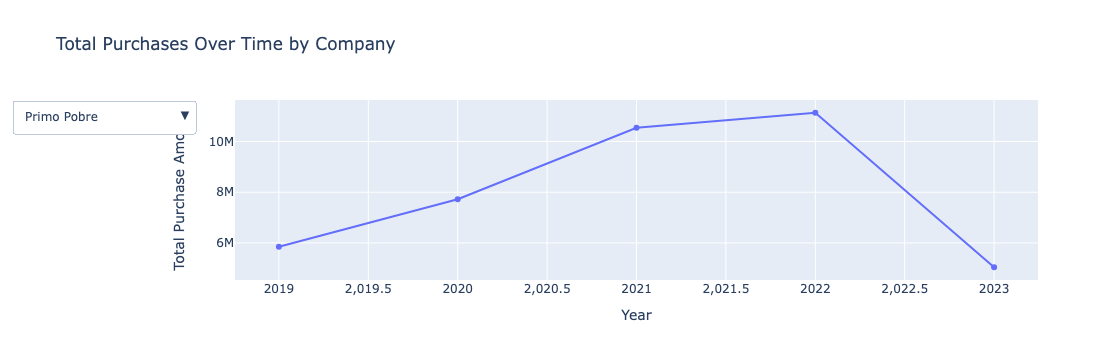

In [132]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Function to create a figure for a specific company
def create_figure(company):
    filtered_df = company_purchases_yearly[company_purchases_yearly['COMPANY_NAME'] == company]
    fig = px.line(filtered_df, x='year', y='TOTAL_AMOUNT', title=f'Total Purchases Over Time for {company}')
    fig.update_layout(xaxis_title='Year', yaxis_title='Total Purchase Amount')
    return fig

# Create a dropdown menu with Plotly
dropdown_buttons = [
    {
        'label': company,
        'method': 'update',
        'args': [{'visible': [company == comp for comp in top_companies]}]
    }
    for company in top_companies
]

# Create subplots (one for each company initially set to not visible)
fig = make_subplots(rows=1, cols=1)

# Add a trace for each company
for company in top_companies:
    filtered_df = company_purchases_yearly[company_purchases_yearly['COMPANY_NAME'] == company]
    fig.add_trace(
        go.Scatter(x=filtered_df['year'], y=filtered_df['TOTAL_AMOUNT'], mode='lines+markers', name=company),
        row=1, col=1
    )

# Update layout with dropdown menu
fig.update_layout(
    title='Total Purchases Over Time by Company',
    xaxis_title='Year',
    yaxis_title='Total Purchase Amount',
    updatemenus=[{
        'buttons': dropdown_buttons,
        'direction': 'down',
        'showactive': True
    }]
)

# Initially, show the first company's data only
fig.update_traces(visible=False)
fig.data[0].visible = True

fig.show()

In [133]:
supplier_purchases_yearly = df_top_suppliers.groupby(['SUPPLIER_NAME', 'year'])['PROD_UNIT_PRICE'].sum().reset_index()

In [134]:
supplier_purchases_yearly

,SUPPLIER_NAME,year,PROD_UNIT_PRICE
0,AMBEV,2018,4162.552
1,AMBEV,2019,28764.613
2,AMBEV,2020,19025.281
3,AMBEV,2021,43034.045
4,AMBEV,2022,63989.664
...,...,...,...
59,SUPER ADEGA,2020,61256.091
60,SUPER ADEGA,2021,126647.541
61,SUPER ADEGA,2022,84952.121
62,SUPER ADEGA,2023,39857.285


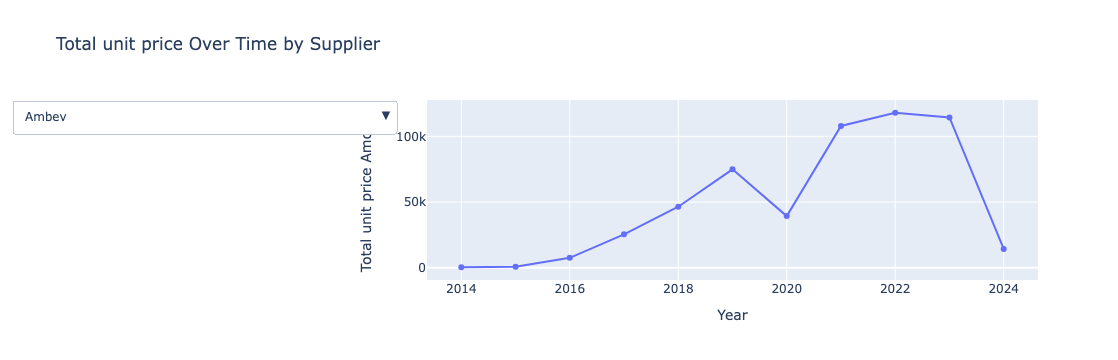

In [135]:
# Function to create a figure for a specific supplier
def create_figure(supplier):
    filtered_df = supplier_purchases_yearly[supplier_purchases_yearly['SUPPLIER_NAME'] == supplier]
    fig = px.line(filtered_df, x='year', y='PROD_UNIT_PRICE', title=f'Total Purchases Over Time for {supplier}')
    fig.update_layout(xaxis_title='Year', yaxis_title='Total unit price')
    return fig

# Create a dropdown menu with Plotly
dropdown_buttons = [
    {
        'label': supplier,
        'method': 'update',
        'args': [{'visible': [supplier == sup for sup in top_suppliers]}]
    }
    for supplier in top_suppliers
]

# Create subplots (one for each supplier initially set to not visible)
fig = make_subplots(rows=1, cols=1)

# Add a trace for each supplier
for supplier in top_suppliers:
    filtered_df = supplier_purchases_yearly[supplier_purchases_yearly['SUPPLIER_NAME'] == supplier]
    fig.add_trace(
        go.Scatter(x=filtered_df['year'], y=filtered_df['PROD_UNIT_PRICE'], mode='lines+markers', name=supplier),
        row=1, col=1
    )

# Update layout with dropdown menu
fig.update_layout(
    title='Total unit price Over Time by Supplier',
    xaxis_title='Year',
    yaxis_title='Total unit price Amount',
    updatemenus=[{
        'buttons': dropdown_buttons,
        'direction': 'down',
        'showactive': True
    }]
)

# Initially, show the first supplier's data only
fig.update_traces(visible=False)
fig.data[0].visible = True

fig.show()

# Prototype of an alert system for effective purchasing efficiency

In [156]:
from datetime import datetime
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [143]:
purchase_data.columns

Index(['COMPANY_CODE', 'SUPPLIER_CODE', 'INVOICE_ID', 'INVOICE_DATE',
       'SUPPLIER_PRODUCT_ID', 'RESTURANT_PRODUCT_ID', 'COMPANY_NAME',
       'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'RESTURANT_PRODUCT',
       'PROD_UNIT_PRICE', 'PROD_QTY', 'TOTAL_AMOUNT', 'Cmp_DtGerencial',
       'imputed_invoice_date', 'COMPANY_CODE_CODE', 'SUPPLIER_CODE_CODE',
       'SUPPLIER_PRODUCT_ID_CODE', 'day_of_week', 'month',
       'normalized_purchase_price', 'log_purchase_price',
       'log_prod_unit_price', 'log_prod_qty', 'year', 'day', 'YearMonth',
       'avg_unit_price_monthly', 'AVERAGE_UNIT_PRICE', 'PRICE_COMPARISON'],
      dtype='object')

In [138]:
# Step 2: Filter for two month back period
latest_invoice_date = purchase_data['INVOICE_DATE'].max()
start_date = latest_invoice_date - timedelta(days=60)  
end_date = latest_invoice_date

In [139]:
#Filter data for the last two months
historical_data = purchase_data[(purchase_data['INVOICE_DATE'] >= start_date) & (purchase_data['INVOICE_DATE'] <= end_date)]


In [166]:
historical_data['INVOICE_DATE'].min()

Timestamp('2023-12-28 00:00:00')

In [144]:
#Calculate average prices per supplier, item, company
avg_prices = historical_data.groupby(['SUPPLIER_CODE_CODE', 'SUPPLIER_PRODUCT_ID_CODE', 'COMPANY_CODE_CODE'])['PROD_UNIT_PRICE'].mean().reset_index()


# Feature engineering: Calculate historical average prices
historical_avg_prices = historical_data.groupby(['SUPPLIER_CODE_CODE', 'SUPPLIER_PRODUCT_ID_CODE'])['PROD_UNIT_PRICE'].mean().reset_index()
historical_avg_prices.rename(columns={'PROD_UNIT_PRICE': 'historical_avg_price'}, inplace=True)


In [152]:
purchase_data.columns

Index(['COMPANY_CODE', 'SUPPLIER_CODE', 'INVOICE_ID', 'INVOICE_DATE',
       'SUPPLIER_PRODUCT_ID', 'RESTURANT_PRODUCT_ID', 'COMPANY_NAME',
       'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'RESTURANT_PRODUCT',
       'PROD_UNIT_PRICE', 'PROD_QTY', 'TOTAL_AMOUNT', 'Cmp_DtGerencial',
       'imputed_invoice_date', 'COMPANY_CODE_CODE', 'SUPPLIER_CODE_CODE',
       'SUPPLIER_PRODUCT_ID_CODE', 'day_of_week', 'month',
       'normalized_purchase_price', 'log_purchase_price',
       'log_prod_unit_price', 'log_prod_qty', 'year', 'day', 'YearMonth',
       'avg_unit_price_monthly', 'AVERAGE_UNIT_PRICE', 'PRICE_COMPARISON',
       'historical_avg_price'],
      dtype='object')

In [151]:
# Merge historical average prices back to main dataset
purchase_data = pd.merge(purchase_data, historical_avg_prices, on=['SUPPLIER_CODE_CODE', 'SUPPLIER_PRODUCT_ID_CODE'], how='left')


In [177]:
# Calculate interaction features
purchase_data['SUPPLIER_ITEM_AVG_PRICE'] = purchase_data.groupby(['SUPPLIER_CODE', 'SUPPLIER_PRODUCT_ID'])['PROD_UNIT_PRICE'].transform('mean')
purchase_data['SUPPLIER_ITEM_COMPANY_COUNT'] = purchase_data.groupby(['SUPPLIER_CODE', 'SUPPLIER_PRODUCT_ID'])['COMPANY_CODE'].transform('nunique')

In [230]:
#purchase_data['log_prod_qty'].
nan_rows = purchase_data[purchase_data['log_prod_qty'].isnull()]

In [233]:
purchase_data['log_prod_qty'].fillna(0, inplace=True)

In [234]:
# Split data into training and test sets
features = ['COMPANY_CODE_CODE', 'SUPPLIER_CODE_CODE', 'SUPPLIER_PRODUCT_ID_CODE', 'year', 'month','SUPPLIER_ITEM_AVG_PRICE','SUPPLIER_ITEM_COMPANY_COUNT','log_prod_qty']
X = purchase_data[features]
y = purchase_data['PROD_UNIT_PRICE']

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [290]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [292]:
# Example: Use RandomForestRegressor with GridSearchCV for hyperparameter tuning
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
# Example: Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [236]:
# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/va

RandomForestRegressor(random_state=42)

In [237]:
# Predict prices for the test set
y_pred = model.predict(X_test)

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [238]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 67588.85553254749
Mean Absolute Error: 4.052421277948815


/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.



In [118]:
# Step 4: Detect price differences
alerts = []
threshold_percent = 10  # Example threshold: 10% higher price alert

for item, supplier, company1, price1 in zip(avg_prices['SUPPLIER_PRODUCT'], avg_prices['SUPPLIER_NAME'], avg_prices['COMPANY_CODE'], avg_prices['PROD_UNIT_PRICE']):
    for company2, price2 in zip(avg_prices['COMPANY_CODE'], avg_prices['PROD_UNIT_PRICE']):
        if company1 != company2 and price1 > price2 * (1 + threshold_percent / 100):
            alert_msg = f"Alert: Supplier {supplier} selling {item} to {company1} at ${price1:.2f}, which is {threshold_percent}% higher than to {company2} at ${price2:.2f}"
            alerts.append(alert_msg)


In [223]:
alerts.columns

Index(['COMPANY_CODE', 'SUPPLIER_CODE', 'INVOICE_ID', 'INVOICE_DATE',
       'SUPPLIER_PRODUCT_ID', 'RESTURANT_PRODUCT_ID', 'COMPANY_NAME',
       'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'RESTURANT_PRODUCT',
       'PROD_UNIT_PRICE', 'PROD_QTY', 'TOTAL_AMOUNT', 'Cmp_DtGerencial',
       'imputed_invoice_date', 'COMPANY_CODE_CODE', 'SUPPLIER_CODE_CODE',
       'SUPPLIER_PRODUCT_ID_CODE', 'day_of_week', 'month',
       'normalized_purchase_price', 'log_purchase_price',
       'log_prod_unit_price', 'log_prod_qty', 'year', 'day', 'YearMonth',
       'avg_unit_price_monthly', 'AVERAGE_UNIT_PRICE', 'PRICE_COMPARISON',
       'historical_avg_price', 'SUPPLIER_ITEM_AVG_PRICE',
       'SUPPLIER_ITEM_COMPANY_COUNT', 'predicted_price', 'potential_savings'],
      dtype='object')

In [ ]:
def generate_alerts(df, model):
    df['predicted_price'] = model.predict(df[features])
    df['potential_savings'] = (df['PROD_UNIT_PRICE'] - df['predicted_price']) * df['PROD_QTY']
    alerts = df[df['potential_savings'] > 0]  # Only consider potential savings
    return alerts

In [280]:
def generate_alerts(df, model):
    # Predict prices
    df['predicted_price'] = model.predict(df[features])
    # Calculate potential savings
    df['potential_savings'] = (df['PROD_UNIT_PRICE'] - df['predicted_price']) * df['PROD_QTY']
    # Filter alerts to include only where potential savings are greater than 0 and unit price is higher than predicted price
    alerts = df[(df['potential_savings'] > 0) & (df['PROD_UNIT_PRICE'] > df['predicted_price'])]
    # Exclude cases where PROD_UNIT_PRICE is equal to predicted_price
    alerts = alerts[alerts['PROD_UNIT_PRICE'] != alerts['predicted_price']]
    return alerts


In [281]:
# Example usage: Generate alerts for recent purchases (last two months)
recent_data = purchase_data[purchase_data['INVOICE_DATE'] >= start_date]
alerts = generate_alerts(recent_data, model)

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/var/folders/jn/36h36k5x2jx5yg4d_l3hvv900000gn/T/ipykernel_40964/1700542593.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [372]:
alerts


rslt_df = alerts[alerts['COMPANY_CODE'] == '1015'] 
rslt_df

,COMPANY_CODE,SUPPLIER_CODE,INVOICE_ID,INVOICE_DATE,SUPPLIER_PRODUCT_ID,RESTURANT_PRODUCT_ID,COMPANY_NAME,SUPPLIER_NAME,SUPPLIER_PRODUCT,RESTURANT_PRODUCT,...,day,YearMonth,avg_unit_price_monthly,AVERAGE_UNIT_PRICE,PRICE_COMPARISON,historical_avg_price,SUPPLIER_ITEM_AVG_PRICE,SUPPLIER_ITEM_COMPANY_COUNT,predicted_price,potential_savings
11,1015,156,3256,2024-02-19,27,246,Joy Flavors,NOBORU HORTIFRUTI EIRELI - ME,CEBOLA,Cebola Branca,...,19,2024-02-01,8.625556,10.571412,below,6.012500,4.751339,1,6.24590,9.608498
14,1015,156,3247,2024-02-15,27,246,Joy Flavors,NOBORU HORTIFRUTI EIRELI - ME,CEBOLA,Cebola Branca,...,15,2024-02-01,8.625556,10.571412,below,6.012500,4.751339,1,6.17200,19.281354
22,1015,156,3234,2024-02-05,27,246,Joy Flavors,NOBORU HORTIFRUTI EIRELI - ME,CEBOLA,Cebola Branca,...,5,2024-02-01,8.625556,10.571412,below,6.012500,4.751339,1,6.17526,7.656660
26,1015,156,3226,2024-02-01,27,246,Joy Flavors,NOBORU HORTIFRUTI EIRELI - ME,CEBOLA,Cebola Branca,...,1,2024-02-01,8.625556,10.571412,below,6.012500,4.751339,1,5.94810,24.818446
1736,1015,156,3212,2024-01-26,55,263,Joy Flavors,NOBORU HORTIFRUTI EIRELI - ME,TOMATE LONGA VIDA,Tomate Para Salada,...,26,2024-01-01,6.296923,13.679068,below,5.390909,5.272800,1,5.93750,3.390104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277493,1015,40,3185,2024-01-10,431,685,Joy Flavors,CASA DE DOCES E QUEIJOS BRASIL,BRIE CAMPO LINDO FORMA POLENGHI KG,Queijo Brie,...,10,2024-01-01,79.900000,79.900000,above,79.900000,79.900000,1,79.76761,0.539667
278910,1015,142,3183,2024-01-09,7896052406081,596,Joy Flavors,OESA COMERCIO E REPRESENTACOES SA,BV CARNE SECA TRAS 5KG PAINEIRA,Carne De Charque / Seca,...,9,2024-01-01,49.690000,53.702500,below,49.690000,47.358333,1,47.93964,52.821491
284508,1015,185,3173,2023-12-30,P000004000,710,Joy Flavors,RESTAURANTE DAS MINAS LTDA,FILAO RUSTICO,Pao Filao,...,30,2023-12-01,18.000000,16.785714,above,18.000000,16.785714,1,17.98670,0.079800
285185,1015,4,3170,2023-12-29,7897521203408,291,Joy Flavors,Dia-a-dia,MOLHO DE PIMENTA NEVES TRAD 150ML,Molho De Pimenta Pronto,...,29,2023-12-01,2.390000,2.110000,above,2.390000,2.110000,1,2.35949,8.100341


In [283]:
print("\nAlerts for potential cost-saving opportunities:")
alerts[['COMPANY_CODE','COMPANY_NAME', 'SUPPLIER_NAME', 'SUPPLIER_PRODUCT', 'PROD_UNIT_PRICE', 'predicted_price', 'potential_savings']]


Alerts for potential cost-saving opportunities:


,COMPANY_CODE,COMPANY_NAME,SUPPLIER_NAME,SUPPLIER_PRODUCT,PROD_UNIT_PRICE,predicted_price,potential_savings
7,1275,Pinella,DIARIO CERVEJEIRO COMERCIO DE BEBIDAS LTDA,Chope Corina Fiapo,21.00,20.97100,0.870000
9,1506,L E A SORVETERIA LTDA,FRUTOS DO CENTRO OESTE LTDA,PICOLE CAJAMANGA,0.87,0.85800,30.799310
10,608,Shoio,PHD,ALCOOL LIQUIDO HIG 70% JFERES - 1 L,7.42,7.40550,1.981497
11,1015,Joy Flavors,NOBORU HORTIFRUTI EIRELI - ME,CEBOLA,6.50,6.24590,9.608498
12,1275,Pinella,NOBORU HORTIFRUTI EIRELI - ME,CEBOLA,6.30,6.18770,4.457062
...,...,...,...,...,...,...,...
286067,622,COTA MIL - Vila Cinco,Unilever Brasil Ltda,Sorvete KIBON Magnum Mini Bombom Gelado 12X113...,171.62,167.10503,42.740945
286072,671,Caliandra Cafe,OESA COMERCIO E REPRESENTACOES SA,MOLHO SHOYU SUAVE 1L CEREJA,9.66,9.38204,19.283403
286238,2060,Na Seis,CANASTRA DA SERRA ATACADO E VAREJO DE QUEIJOS ...,LINGUIÇA DE FORMIGA-MG TRADICIONAL,18.50,18.33134,3.373200
286281,1822,Barziin Gastrobar,OESA COMERCIO E REPRESENTACOES SA,DETERGENTE NEUTRO 5L MPQ,21.01,20.96226,0.910832


In [293]:
def check_company_savings(company_id, recent_data, model):
    # Filter data for the specific company
    company_data = recent_data[recent_data['COMPANY_CODE'] == company_id]
    
    # Generate alerts
    alerts = generate_alerts(company_data, model)
    
    if alerts.empty:
        print(f"No potential savings found for company ID {company_id} in the recent data.")
    else:
        print(f"\nPotential savings for company ID {company_id} in the recent data:")
        
        # Remove alerts where potential savings is 0 or unit price and predicted price are the same
        alerts = alerts[(alerts['potential_savings'] > 0) & (alerts['PROD_UNIT_PRICE'] != alerts['predicted_price'])]
        
        if alerts.empty:
            print(f"No valid alerts found for company ID {company_id}.")
            return
        
        # Calculate total potential savings
        total_savings = alerts['potential_savings'].sum()
        print(f"Total potential savings: ${total_savings:.2f}")
        
        # Print individual alerts
        for index, row in alerts.iterrows():
            print(f"Alert: {row['SUPPLIER_NAME']} selling {row['SUPPLIER_PRODUCT']} to {row['COMPANY_CODE']} at "
                  f"${row['PROD_UNIT_PRICE']:.2f}, which is higher than the predicted price of ${row['predicted_price']:.2f}. "
                  f"Potential savings: ${row['potential_savings']:.2f}")
        
        # Plot total potential savings as an indicator
        indicator_fig = go.Figure(go.Indicator(
            mode="number",
            value=total_savings,
            title={"text": f"Total Potential Savings for Company ID {company_id}"}
        ))
        indicator_fig.show()
        
        # Plot top 10 items by potential savings
        top_items = alerts.groupby('SUPPLIER_PRODUCT')['potential_savings'].sum().nlargest(10)
        bar_fig = px.bar(top_items, x=top_items.index, y=top_items.values, labels={'x': 'Item', 'y': 'Potential Savings'},
                         title='Top 10 Items by Potential Savings')
        bar_fig.show()

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.




Potential savings for company ID 1275 in the recent data:
Total potential savings: $7679.14
Alert: DIARIO CERVEJEIRO COMERCIO DE BEBIDAS LTDA selling Chope Corina Fiapo to 1275 at $21.00, which is higher than the predicted price of $20.97. Potential savings: $0.87
Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1275 at $6.30, which is higher than the predicted price of $6.19. Potential savings: $4.46
Alert: DIARIO CERVEJEIRO COMERCIO DE BEBIDAS LTDA selling Chope Corina Fiapo to 1275 at $21.00, which is higher than the predicted price of $20.97. Potential savings: $0.87
Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1275 at $6.30, which is higher than the predicted price of $6.25. Potential savings: $1.77
Alert: DIARIO CERVEJEIRO COMERCIO DE BEBIDAS LTDA selling Chope Corina Fiapo to 1275 at $21.00, which is higher than the predicted price of $20.97. Potential savings: $0.87
Alert: DIARIO CERVEJEIRO COMERCIO DE BEBIDAS LTDA selling Chope Corina Fiapo to 1275 at $21.00, 

/var/folders/jn/36h36k5x2jx5yg4d_l3hvv900000gn/T/ipykernel_40964/1700542593.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jn/36h36k5x2jx5yg4d_l3hvv900000gn/T/ipykernel_40964/1700542593.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



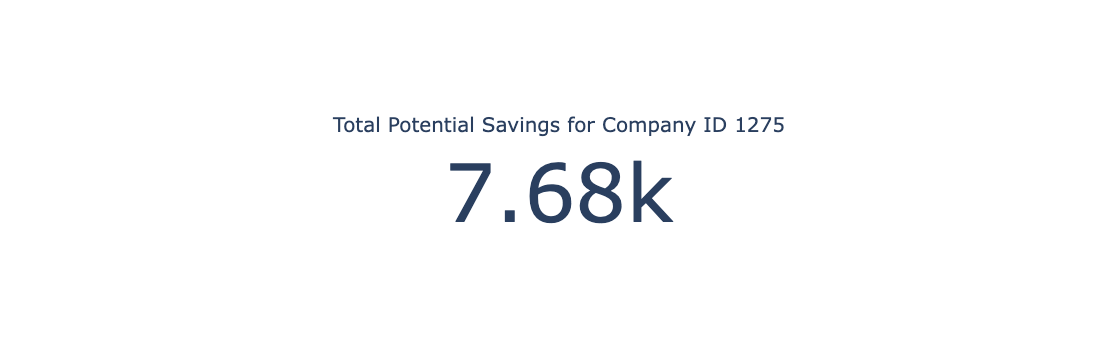

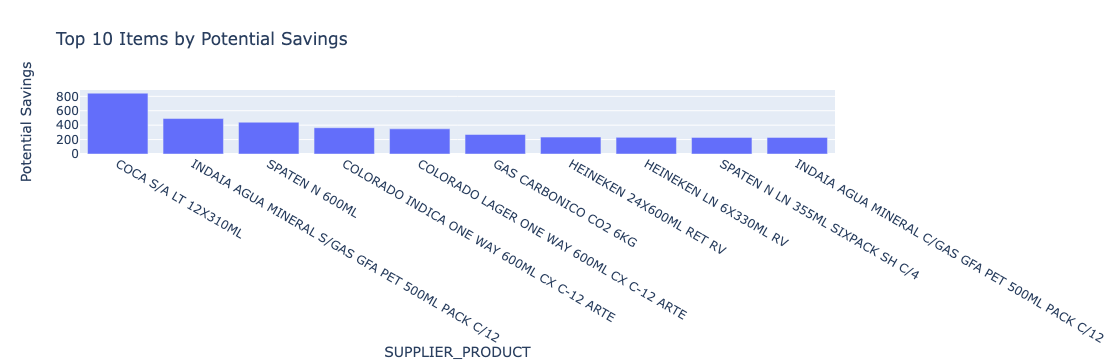

In [294]:
# Example usage: Check potential savings for a specific company
company_id_to_check = '1275'
check_company_savings(company_id_to_check, recent_data, model)

In [312]:
HIGH_SAVING_THRESHOLD_PERCENT = 1  # 20% savings
MEDIUM_SAVING_THRESHOLD_PERCENT = 0.5  # 10% savings
LOW_SAVING_THRESHOLD_PERCENT =0.1   # 5% savings

In [297]:
def generate_alerts(df, model):
    df['predicted_price'] = model.predict(df[features])
    df['potential_savings'] = (df['PROD_UNIT_PRICE'] - df['predicted_price']) * df['PROD_QTY']
    df['potential_savings_percent'] = (df['PROD_UNIT_PRICE'] - df['predicted_price']) / df['predicted_price'] * 100
    alerts = df[(df['potential_savings'] > 0) & (df['PROD_UNIT_PRICE'] != df['predicted_price'])]
    return alerts

In [314]:

def generate_alerts(df, model):
    # Predict prices
    df['predicted_price'] = model.predict(df[features])
    # Calculate potential savings
    df['potential_savings'] = (df['PROD_UNIT_PRICE'] - df['predicted_price']) * df['PROD_QTY']
    df['potential_savings_percent'] = (df['PROD_UNIT_PRICE'] - df['predicted_price']) / df['predicted_price'] * 100
    # Filter alerts to include only where potential savings are greater than 0 and unit price is higher than predicted price
    alerts = df[(df['potential_savings'] > 0) & (df['PROD_UNIT_PRICE'] > df['predicted_price'])]
    # Exclude cases where PROD_UNIT_PRICE is equal to predicted_price
    alerts = alerts[alerts['PROD_UNIT_PRICE'] != alerts['predicted_price']]
    return alerts


In [323]:
# Function to generate flags based on potential savings percentage
def generate_flags(potential_savings_percent):
    if potential_savings_percent >= HIGH_SAVING_THRESHOLD_PERCENT:
        return 'red'
    elif potential_savings_percent >= MEDIUM_SAVING_THRESHOLD_PERCENT:
        return 'yellow'
    elif potential_savings_percent >= LOW_SAVING_THRESHOLD_PERCENT:
        return 'green'
    else:
        return 'none'

In [325]:
# Function to generate and display alerts for a selected item
def check_item_savings(company_id, item_name, recent_data, model, only_red_alerts=False):
    # Filter data for the specific item and company
    item_data = recent_data[(recent_data['SUPPLIER_PRODUCT'] == item_name) & (recent_data['COMPANY_CODE'] == company_id)]
    
    # Generate alerts
    alerts = generate_alerts(item_data, model)    
    if alerts.empty:
        print(f"No potential savings found for item {item_name}.")
    else:
        # Remove alerts where potential savings is 0 or unit price and predicted price are the same
        alerts = alerts[(alerts['potential_savings'] > 0) & (alerts['PROD_UNIT_PRICE'] != alerts['predicted_price'])]
        
        if alerts.empty:
            print(f"No valid alerts found for item {item_name}.")
            return
        
        # Calculate total potential savings
        total_savings = alerts['potential_savings'].sum()
        print(f"\nTotal potential savings for item {item_name}: ${total_savings:.2f}")
        
        # Apply flag color filter if only_red_alerts is True
        if only_red_alerts:
            alerts['flag'] = alerts['potential_savings_percent'].apply(generate_flags)
            #print(alerts)
            alerts = alerts[alerts['flag'] == 'red']
            if alerts.empty:
                print(f"No red alerts found for item {item_name}.")
                return
        
        # Print individual alerts with flags
        for index, row in alerts.iterrows():
            flag = generate_flags(row['potential_savings_percent'])
            flag_color = 'black' if flag == 'none' else flag
            print(f"Alert: {row['SUPPLIER_NAME']} selling {row['SUPPLIER_PRODUCT']} to {row['COMPANY_CODE']} at "
                  f"${row['PROD_UNIT_PRICE']:.2f}, which is higher than the predicted price of ${row['predicted_price']:.2f}. "
                  f"Potential savings: ${row['potential_savings']:.2f} ({row['potential_savings_percent']:.2f}%) Flag: {flag}")


In [328]:
# ANSI escape sequences for text colors
class colors:
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    RESET = '\033[0m'  # Reset to default color

In [331]:
# Function to generate and display alerts for a selected item
def check_item_savings(company_id, item_name, recent_data, model, only_red_alerts=False):
    # Filter data for the specific item and company
    item_data = recent_data[(recent_data['SUPPLIER_PRODUCT'] == item_name) & (recent_data['COMPANY_CODE'] == company_id)]
    
    # Generate alerts
    alerts = generate_alerts(item_data, model)
    
    if alerts.empty:
        print(f"No potential savings found for item {item_name}.")
    else:
        # Remove alerts where potential savings is 0 or unit price and predicted price are the same
        alerts = alerts[(alerts['potential_savings'] > 0) & (alerts['PROD_UNIT_PRICE'] != alerts['predicted_price'])]
        
        if alerts.empty:
            print(f"No valid alerts found for item {item_name}.")
            return
        
        # Calculate total potential savings
        total_savings = alerts['potential_savings'].sum()
        print(f"\nTotal potential savings for item {item_name}: ${total_savings:.2f}")

          # Apply flag color filter if only_red_alerts is True
        if only_red_alerts:
            alerts['flag'] = alerts['potential_savings_percent'].apply(generate_flags)
            # Filter alerts to only show those with red or yellow flags
            alerts = alerts[(alerts['flag'] == 'red') | (alerts['flag'] == 'yellow')]
            
            # If no red or yellow alerts are found, print a message
            if alerts.empty:
                print(f"No red or yellow alerts found for item {item_name}.")
                return
        
     
        
        # Print individual alerts with flags and highlight text based on flag color
        for index, row in alerts.iterrows():
            flag = generate_flags(row['potential_savings_percent'])
            if flag == 'green':
                flag_color = colors.GREEN
            elif flag == 'yellow':
                flag_color = colors.YELLOW
            elif flag == 'red':
                flag_color = colors.RED
            else:
                flag_color = colors.RESET
            
            # Print alert with highlighted text
            print(f"Alert: {flag_color}{row['SUPPLIER_NAME']} selling {row['SUPPLIER_PRODUCT']} to {row['COMPANY_CODE']} at "
                  f"${row['PROD_UNIT_PRICE']:.2f}, which is higher than the predicted price of ${row['predicted_price']:.2f}. "
                  f"Potential savings: ${row['potential_savings']:.2f} ({row['potential_savings_percent']:.2f}%) Flag: {flag}{colors.RESET}")


In [358]:
# Function to generate and display alerts for a selected item
def check_item_savings(company_id, item_name, recent_data, model, only_red_alerts=False):
    # Filter data for the specific item and company
    item_data = recent_data[(recent_data['SUPPLIER_PRODUCT'] == item_name) & (recent_data['COMPANY_CODE'] == company_id)]
    
    # Generate alerts
    alerts = generate_alerts(item_data, model)
    
    if alerts.empty:
        print(f"No potential savings found for item {item_name}.")
    else:
        # Remove alerts where potential savings is 0 or unit price and predicted price are the same
        alerts = alerts[(alerts['potential_savings'] > 0) & (alerts['PROD_UNIT_PRICE'] != alerts['predicted_price'])]
        
        if alerts.empty:
            print(f"No valid alerts found for item {item_name}.")
            return

        
        
        # Calculate total potential savings
        total_savings = alerts['potential_savings'].sum()
        #print(f"\nTotal potential savings for item {item_name}: ${total_savings:.2f}")

        # Plot total potential savings as an indicator
        indicator_fig = go.Figure(go.Indicator(
            mode="number",
            value=total_savings,
            title={"text": f"Total Potential Savings for Company ID and Item  {company_id} and {item_name} "}
        ))
        indicator_fig.show()
        
        # Apply flag color filter if only_red_alerts is True
        if only_red_alerts:
            alerts['flag'] = alerts['potential_savings_percent'].apply(generate_flags)
            # Filter alerts to only show those with red or yellow flags
            alerts = alerts[(alerts['flag'] == 'red') | (alerts['flag'] == 'yellow')]
            
            # If no red or yellow alerts are found, print a message
            if alerts.empty:
                print(f"No red or yellow alerts found for item {item_name}.")
                return
        
        # Fetch prices for other companies buying at prices lower than your predicted price
        other_companies_data = recent_data[
            (recent_data['SUPPLIER_PRODUCT'] == item_name) & 
            (recent_data['COMPANY_CODE'] != company_id) & 
            (recent_data['PROD_UNIT_PRICE'] < item_data['PROD_UNIT_PRICE'].iloc[0])
        ]
        
        # Calculate average price from other companies
        avg_price = other_companies_data['PROD_UNIT_PRICE'].mean()
        
        # Print individual alerts with flags, predicted price, average price, and potential savings
        for index, row in alerts.iterrows():
            flag = generate_flags(row['potential_savings_percent'])
            if flag == 'yellow':
                flag_color = colors.YELLOW
            elif flag == 'red':
                flag_color = colors.RED
            else:
                flag_color = colors.RESET
            
            # Print alert with highlighted text, predicted price, average price, and other companies' prices
            print(f"Alert: {flag_color}{row['SUPPLIER_NAME']} selling {row['SUPPLIER_PRODUCT']} to {row['COMPANY_CODE']} at "
                  f"${row['PROD_UNIT_PRICE']:.2f}, which is higher than the predicted price of ${row['predicted_price']:.2f}. "
                  f"Potential savings: ${row['potential_savings']:.2f} ({row['potential_savings_percent']:.2f}%) Flag: {flag}{colors.RESET}"
                  f"\n   Predicted price: ${row['predicted_price']:.2f}"
                  f"\n   Average price from other companies (your unit price) : ${avg_price:.2f}")


        


/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/Users/ashutoshkumarsonu/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

/var/folders/jn/36h36k5x2jx5yg4d_l3hvv900000gn/T/ipykernel_40964/1607466897.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

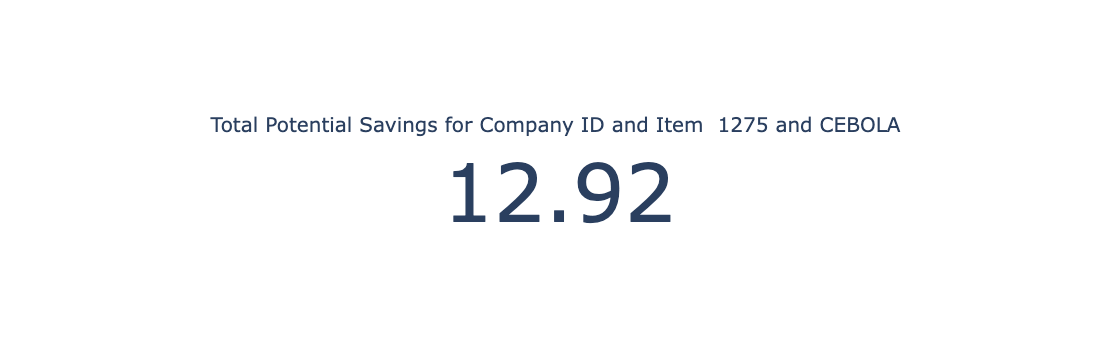

Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1275 at $6.30, which is higher than the predicted price of $6.19. Potential savings: $4.46 (1.81%) Flag: red
   Predicted price: $6.19
   Average price from other companies (your unit price) : $5.72
Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1275 at $6.30, which is higher than the predicted price of $6.25. Potential savings: $1.77 (0.75%) Flag: yellow
   Predicted price: $6.25
   Average price from other companies (your unit price) : $5.72
Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1275 at $5.80, which is higher than the predicted price of $5.73. Potential savings: $2.99 (1.15%) Flag: red
   Predicted price: $5.73
   Average price from other companies (your unit price) : $5.72
Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1275 at $5.80, which is higher than the predicted price of $5.77. Potential savings: $1.14 (0.59%) Flag: yellow
   Predicted price: $5.77
   Average price from other companies (you

In [361]:
# Example usage
item_name = 'CEBOLA'  # Replace with the actual item name you want to check
company_id_to_check = '1275'
check_item_savings(company_id_to_check,item_name, recent_data, model, only_red_alerts=True)

In [374]:
# Function to generate and display alerts for selected items, quantities, and company
def check_item_savings(company_id, item_quantities, recent_data, model, only_red_alerts=False):
    total_savings = 0
    item_summary = []

    for item_name, quantity in item_quantities.items():
        # Filter data for the specific item and company
        item_data = recent_data[(recent_data['SUPPLIER_PRODUCT'] == item_name) & (recent_data['COMPANY_CODE'] == company_id)]
        
        # Check if item_data is empty
        if item_data.empty:
            print(f"No data found for item {item_name} and company {company_id}.")
            continue
        
        # Generate alerts
        alerts = generate_alerts(item_data, model)
        
        if alerts.empty:
            print(f"No potential savings found for item {item_name} and company {company_id}.")
            continue
        
        # Remove alerts where potential savings is 0 or unit price and predicted price are the same
        alerts = alerts[(alerts['potential_savings'] > 0) & (alerts['PROD_UNIT_PRICE'] != alerts['predicted_price'])]
        
        if alerts.empty:
            print(f"No valid alerts found for item {item_name} and company {company_id}.")
            continue
        
        # Calculate total potential savings for the item
        item_total_savings = alerts['potential_savings'].sum()
        total_savings += item_total_savings
        print(f"\nTotal potential savings for item {item_name} and company {company_id}: ${item_total_savings:.2f}")
        
        # Apply flag color filter if only_red_alerts is True
        if only_red_alerts:
            alerts['flag'] = alerts['potential_savings_percent'].apply(generate_flags)
            # Filter alerts to only show those with red or yellow flags
            alerts = alerts[(alerts['flag'] == 'red') | (alerts['flag'] == 'yellow')]
            
            # If no red or yellow alerts are found, print a message
            if alerts.empty:
                print(f"No red or yellow alerts found for item {item_name} and company {company_id}.")
                continue
        
        # Fetch prices for other companies buying at prices lower than your predicted price
        other_companies_data = recent_data[
            (recent_data['SUPPLIER_PRODUCT'] == item_name) & 
            (recent_data['COMPANY_CODE'] != company_id) & 
            (recent_data['PROD_UNIT_PRICE'] < alerts['predicted_price'].iloc[0])
        ]
        
        # Check if other_companies_data is empty
        if other_companies_data.empty:
            avg_price = np.nan
        else:
            # Calculate average price from other companies
            avg_price = other_companies_data['PROD_UNIT_PRICE'].mean()
        
        # Store summary for the item
        item_summary.append({
            'item_name': item_name,
            'total_savings': item_total_savings,
            'alerts': alerts,
            'avg_price': avg_price
        })
        
        # Print individual alerts with flags, predicted price, average price, and potential savings
        for index, row in alerts.iterrows():
            flag = generate_flags(row['potential_savings_percent'])
            if flag == 'yellow':
                flag_color = colors.YELLOW
            elif flag == 'red':
                flag_color = colors.RED
            else:
                flag_color = colors.RESET
            
            avg_price_display = f"${avg_price:.2f}" if not np.isnan(avg_price) else "N/A"
            print(f"Alert: {flag_color}{row['SUPPLIER_NAME']} selling {row['SUPPLIER_PRODUCT']} to {row['COMPANY_CODE']} at "
                  f"${row['PROD_UNIT_PRICE']:.2f}, which is higher than the predicted price of ${row['predicted_price']:.2f}. "
                  f"Potential savings: ${row['potential_savings']:.2f} ({row['potential_savings_percent']:.2f}%) Flag: {flag}{colors.RESET}"
                  f"\n   Predicted price: ${row['predicted_price']:.2f}"
                  f"\n   Average price from other companies (below predicted price): {avg_price_display}")

    # Plot total potential savings as an indicator
    indicator_fig = go.Figure(go.Indicator(
        mode="number",
        value=total_savings,
        title={"text": f"Total Potential Savings for Company {company_id}"}
    ))
    indicator_fig.show()
    
    # Plot items in potential savings as a bar chart
    top_items = sorted(item_summary, key=lambda x: x['total_savings'], reverse=True)[:10]
    item_names = [item['item_name'] for item in top_items]
    item_savings = [item['total_savings'] for item in top_items]
    
    bar_fig = go.Figure([go.Bar(x=item_names, y=item_savings)])
    bar_fig.update_layout(
        title=f"Items in Potential Savings for Company {company_id}",
        xaxis_title="Item",
        yaxis_title="Potential Savings ($)"
    )
    bar_fig.show()


Total potential savings for item CEBOLA and company 1015: $61.36
Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1015 at $6.50, which is higher than the predicted price of $6.25. Potential savings: $9.61 (4.07%) Flag: red
   Predicted price: $6.25
   Average price from other companies (below predicted price): $5.75
Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1015 at $6.50, which is higher than the predicted price of $6.17. Potential savings: $19.28 (5.31%) Flag: red
   Predicted price: $6.17
   Average price from other companies (below predicted price): $5.75
Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1015 at $6.30, which is higher than the predicted price of $6.18. Potential savings: $7.66 (2.02%) Flag: red
   Predicted price: $6.18
   Average price from other companies (below predicted price): $5.75
Alert: NOBORU HORTIFRUTI EIRELI - ME selling CEBOLA to 1015 at $6.30, which is higher than the predicted price of $5.95. Potential savings: $24.82 (5.92%) F

/var/folders/jn/36h36k5x2jx5yg4d_l3hvv900000gn/T/ipykernel_40964/1607466897.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jn/36h36k5x2jx5yg4d_l3hvv900000gn/T/ipykernel_40964/1607466897.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/jn/36h36k5x2jx5yg4d_l3hvv900000gn/T/ipykernel_40964/1607466897.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

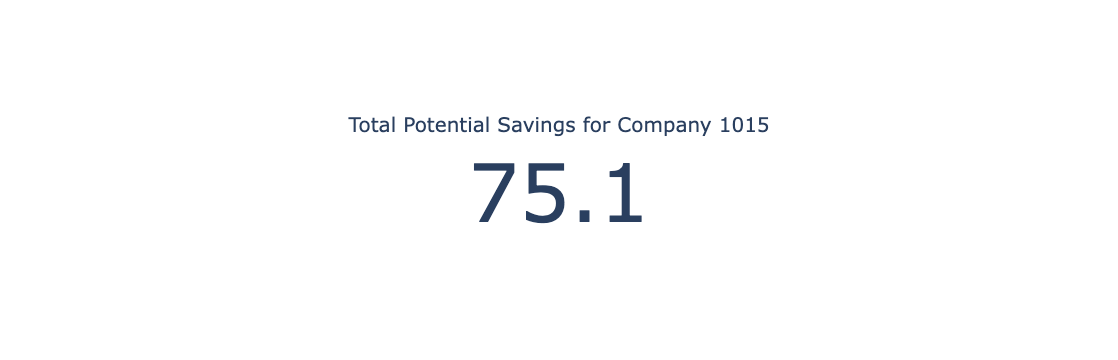

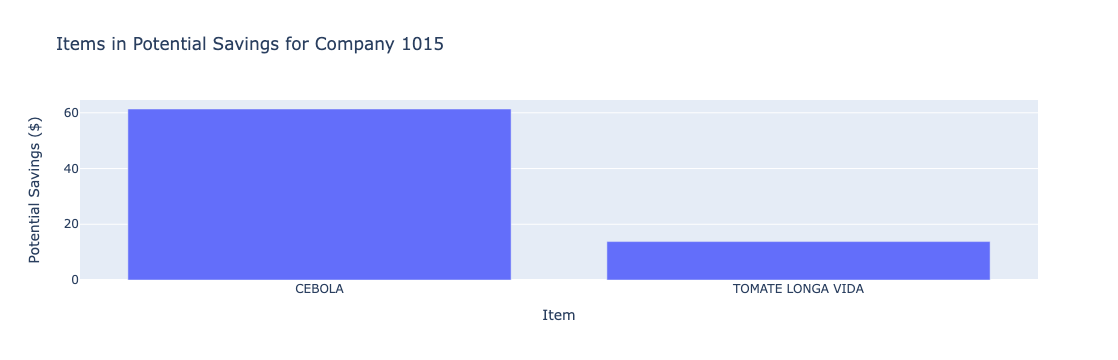

In [378]:
# Example usage
item_quantities = {
    'CEBOLA': 10,
    'TOMATE LONGA VIDA': 15
}
company_id='1015'
check_item_savings(company_id,item_quantities, recent_data, model, only_red_alerts=False)